In [1]:
import numpy as np
import pandas as pd
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

Containment Date Time: The date and time a wildfire was declared contained. 

Control Date Time: The date and time a wildfire was declared under control.

Daily Acres: A measure of acres reported for a fire. More specifically, the number of acres within the current perimeter of a specific, individual incident, including unburned and unburnable islands. The minimum size must be 0.1.

Discovery Acres: An estimate of acres burning upon the discovery of the fire. More specifically when the fire is first reported by the first person that calls in the fire. The estimate should include number of acres within the current perimeter of a specific, individual incident, including unburned and unburnable islands.

Predominant Fuel Model: Describes the type of fuels found within the  majority of the incident area.

In [2]:
# load data
pd.options.display.max_columns = None
fires = pd.read_csv("WFIGS_-_Wildland_Fire_Locations_Full_History.csv")
fires = fires[['ControlDateTime','ContainmentDateTime','FireDiscoveryDateTime','POOState','PredominantFuelModel','FireCauseGeneral','DailyAcres','DiscoveryAcres','InitialLatitude','InitialLongitude']]

#round the lat and long to align with project
fires['latitude_rounded'] = round(fires['InitialLatitude'], 2)
fires['longitude_rounded'] = round(fires['InitialLongitude'], 2)
fires.count()

ControlDateTime          116396
ContainmentDateTime      127273
FireDiscoveryDateTime    211537
POOState                 211537
PredominantFuelModel      33469
FireCauseGeneral          50803
DailyAcres               144424
DiscoveryAcres           151655
InitialLatitude          152050
InitialLongitude         152050
latitude_rounded         152050
longitude_rounded        152050
dtype: int64

In [3]:
fires['DiscoveryAcres'].fillna(fires['DiscoveryAcres'].min(), inplace=True)
fires['DailyAcres'].fillna(0.1, inplace=True)
fires.isnull().sum()

ControlDateTime           95141
ContainmentDateTime       84264
FireDiscoveryDateTime         0
POOState                      0
PredominantFuelModel     178068
FireCauseGeneral         160734
DailyAcres                    0
DiscoveryAcres                0
InitialLatitude           59487
InitialLongitude          59487
latitude_rounded          59487
longitude_rounded         59487
dtype: int64

In [4]:
# check time frame errors
fires['CorrectControlDateTime'] = pd.to_datetime(fires['ControlDateTime'],errors='coerce')
errors = fires.loc[fires['CorrectControlDateTime'].isnull()]['ControlDateTime'].unique().tolist()
errors

[nan,
 '0214/08/14 21:34:00+00',
 '0214/08/05 07:00:00+00',
 '1159/10/22 17:00:00+00']

In [5]:
correct_dict = {'0214/08/14 21:34:00+00' : '2014/08/14 21:34:00+00',
                '0214/08/05 07:00:00+00' : '2014/08/05 07:00:00+00',
                '1159/10/22 17:00:00+00' : '2014/08/03 17:00:00+00'}
fires['ControlDateTime'] = fires['CorrectControlDateTime'].fillna(pd.to_datetime(fires['ControlDateTime'].map(correct_dict)))


In [6]:
fires['CorrectContainmentDateTime'] = pd.to_datetime(fires['ContainmentDateTime'],errors='coerce')
errors = fires.loc[fires['CorrectContainmentDateTime'].isnull()]['ContainmentDateTime'].unique().tolist()
errors

[nan, '0214/08/06 07:58:00+00']

In [7]:
correct_dict = {'0214/08/06 07:58:00+00' : '2014/08/06 07:58:00+00'}
fires['ContainmentDateTime'] = fires['CorrectContainmentDateTime'].fillna(pd.to_datetime(fires['ContainmentDateTime'].map(correct_dict)))


In [8]:
# fillna with values from another column

#fires['ControlDateTime'].fillna(fires['ContainmentDateTime'], inplace=True)

fires['ControlDateTime'].isnull().sum()

95141

In [9]:
fires['ControlDateTime'] = (pd.to_datetime(fires['ControlDateTime'],errors='coerce').dt.strftime('%Y/%m/%d %H:%M:%S'))
fires['ContainmentDateTime'] = (pd.to_datetime(fires['ContainmentDateTime'],errors='coerce').dt.strftime('%Y/%m/%d %H:%M:%S'))
fires['FireDiscoveryDateTime'] = (pd.to_datetime(fires['FireDiscoveryDateTime'],errors='coerce').dt.strftime('%Y/%m/%d %H:%M:%S'))


In [10]:
fires['ControlDateTime'] = pd.to_datetime(fires['ControlDateTime'])
fires['ContainmentDateTime'] = pd.to_datetime(fires['ContainmentDateTime'])
fires['FireDiscoveryDateTime'] = pd.to_datetime(fires['FireDiscoveryDateTime'])

# make new variable of fire duration with date columns
# fire duration base on ControlDateTime
fires['Control_Duration'] = (fires['ControlDateTime'] - fires['FireDiscoveryDateTime'])/np.timedelta64(1,'h')

# fire duration base on ContainmentDateTime
fires['Contain_Duration'] = (fires['ContainmentDateTime'] - fires['FireDiscoveryDateTime'])/np.timedelta64(1,'h')
fires.dropna(subset=['Control_Duration', 'Contain_Duration'], inplace=True)
fires

,ControlDateTime,ContainmentDateTime,FireDiscoveryDateTime,POOState,PredominantFuelModel,FireCauseGeneral,DailyAcres,DiscoveryAcres,InitialLatitude,InitialLongitude,latitude_rounded,longitude_rounded,CorrectControlDateTime,CorrectContainmentDateTime,Control_Duration,Contain_Duration
0,2020-08-06 23:13:24,2020-08-06 23:13:07,2020-08-06 18:58:00,US-MT,GR4,Equipment,50.60,20.0,45.78496,-104.49580,45.78,-104.50,2020-08-06 23:13:24+00:00,2020-08-06 23:13:07+00:00,4.256667,4.251944
2,2017-10-18 00:35:00,2017-10-18 00:30:00,2017-10-17 20:20:24,US-MT,NaN,NaN,50.00,50.0,48.07167,-114.83030,48.07,-114.83,2017-10-18 00:35:00+00:00,2017-10-18 00:30:00+00:00,4.243333,4.160000
5,2020-11-24 22:18:00,2020-11-23 20:54:00,2020-11-23 19:17:00,US-MS,SH8,Incendiary,1.00,1.0,31.06819,-89.06972,31.07,-89.07,2020-11-24 22:18:00+00:00,2020-11-23 20:54:00+00:00,27.016667,1.616667
6,2019-11-05 18:30:00,2019-10-31 16:30:00,2019-10-26 21:29:00,US-UT,NaN,NaN,170.00,0.1,40.07631,-111.41820,40.08,-111.42,2019-11-05 18:30:00+00:00,2019-10-31 16:30:00+00:00,237.016667,115.016667
7,2020-08-27 20:52:59,2020-08-27 19:27:00,2020-08-27 14:06:38,US-MT,GR2,Lightning,0.10,0.1,44.65363,-111.56360,44.65,-111.56,2020-08-27 20:52:59+00:00,2020-08-27 19:27:00+00:00,6.772500,5.339444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211509,2022-03-13 02:29:59,2022-03-13 02:00:00,2022-03-12 21:33:00,US-SD,NaN,NaN,0.10,0.1,43.75895,-103.73950,43.76,-103.74,2022-03-13 02:29:59+00:00,2022-03-13 02:00:00+00:00,4.949722,4.450000
211510,2022-03-12 23:40:00,2022-03-12 23:40:00,2022-03-12 21:59:59,US-WA,NaN,NaN,1.00,1.0,46.54008,-121.95610,46.54,-121.96,2022-03-12 23:40:00+00:00,2022-03-12 23:40:00+00:00,1.666944,1.666944
211514,2022-03-11 12:49:00,2022-03-11 12:43:00,2022-03-11 11:10:00,US-ME,NaN,Equipment,0.10,0.0,NaN,NaN,NaN,NaN,2022-03-11 12:49:00+00:00,2022-03-11 12:43:00+00:00,1.650000,1.550000
211523,2022-03-12 18:40:00,2022-03-12 18:40:00,2022-03-12 18:38:00,US-MT,NaN,NaN,0.25,0.3,46.47153,-114.01540,46.47,-114.02,2022-03-12 18:40:00+00:00,2022-03-12 18:40:00+00:00,0.033333,0.033333


In [11]:
print(fires.Control_Duration.describe())
print(fires.Contain_Duration.describe())

count    113429.000000
mean        106.939124
std         479.964371
min      -87580.983333
25%           1.766667
50%          16.816667
75%          53.066667
max        8759.970556
Name: Control_Duration, dtype: float64
count    113429.000000
mean         63.087786
std         332.234534
min       -8758.500000
25%           1.049722
50%           2.866944
75%          18.133611
max        8759.970556
Name: Contain_Duration, dtype: float64


In [12]:
#fires['duration'].fillna(fires['duration'].mean())
fires = pd.DataFrame(fires).dropna(subset = ['latitude_rounded', 'longitude_rounded'])

In [13]:
fires['Year'] = pd.to_datetime(fires['FireDiscoveryDateTime']).dt.year
fires['Date'] = pd.to_datetime(fires['FireDiscoveryDateTime']).dt.date
fires['Time'] = pd.to_datetime(fires['FireDiscoveryDateTime']).dt.time

fires['Date'] = pd.to_datetime(fires['Date']).dt.strftime("%Y-%m-%d")
fires['Time'] = (pd.to_datetime(fires['FireDiscoveryDateTime']).astype(int)/ 10**9).astype(int)

fires

,ControlDateTime,ContainmentDateTime,FireDiscoveryDateTime,POOState,PredominantFuelModel,FireCauseGeneral,DailyAcres,DiscoveryAcres,InitialLatitude,InitialLongitude,latitude_rounded,longitude_rounded,CorrectControlDateTime,CorrectContainmentDateTime,Control_Duration,Contain_Duration,Year,Date,Time
0,2020-08-06 23:13:24,2020-08-06 23:13:07,2020-08-06 18:58:00,US-MT,GR4,Equipment,50.60,20.0,45.78496,-104.49580,45.78,-104.50,2020-08-06 23:13:24+00:00,2020-08-06 23:13:07+00:00,4.256667,4.251944,2020,2020-08-06,1596740280
2,2017-10-18 00:35:00,2017-10-18 00:30:00,2017-10-17 20:20:24,US-MT,NaN,NaN,50.00,50.0,48.07167,-114.83030,48.07,-114.83,2017-10-18 00:35:00+00:00,2017-10-18 00:30:00+00:00,4.243333,4.160000,2017,2017-10-17,1508271624
5,2020-11-24 22:18:00,2020-11-23 20:54:00,2020-11-23 19:17:00,US-MS,SH8,Incendiary,1.00,1.0,31.06819,-89.06972,31.07,-89.07,2020-11-24 22:18:00+00:00,2020-11-23 20:54:00+00:00,27.016667,1.616667,2020,2020-11-23,1606159020
6,2019-11-05 18:30:00,2019-10-31 16:30:00,2019-10-26 21:29:00,US-UT,NaN,NaN,170.00,0.1,40.07631,-111.41820,40.08,-111.42,2019-11-05 18:30:00+00:00,2019-10-31 16:30:00+00:00,237.016667,115.016667,2019,2019-10-26,1572125340
7,2020-08-27 20:52:59,2020-08-27 19:27:00,2020-08-27 14:06:38,US-MT,GR2,Lightning,0.10,0.1,44.65363,-111.56360,44.65,-111.56,2020-08-27 20:52:59+00:00,2020-08-27 19:27:00+00:00,6.772500,5.339444,2020,2020-08-27,1598537198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211489,2022-03-11 18:00:00,2022-03-11 00:00:00,2022-03-10 18:24:00,US-OK,NaN,NaN,3.30,1.0,36.53883,-96.27298,36.54,-96.27,2022-03-11 18:00:00+00:00,2022-03-11 00:00:00+00:00,23.600000,5.600000,2022,2022-03-10,1646936640
211509,2022-03-13 02:29:59,2022-03-13 02:00:00,2022-03-12 21:33:00,US-SD,NaN,NaN,0.10,0.1,43.75895,-103.73950,43.76,-103.74,2022-03-13 02:29:59+00:00,2022-03-13 02:00:00+00:00,4.949722,4.450000,2022,2022-03-12,1647120780
211510,2022-03-12 23:40:00,2022-03-12 23:40:00,2022-03-12 21:59:59,US-WA,NaN,NaN,1.00,1.0,46.54008,-121.95610,46.54,-121.96,2022-03-12 23:40:00+00:00,2022-03-12 23:40:00+00:00,1.666944,1.666944,2022,2022-03-12,1647122399
211523,2022-03-12 18:40:00,2022-03-12 18:40:00,2022-03-12 18:38:00,US-MT,NaN,NaN,0.25,0.3,46.47153,-114.01540,46.47,-114.02,2022-03-12 18:40:00+00:00,2022-03-12 18:40:00+00:00,0.033333,0.033333,2022,2022-03-12,1647110280


In [14]:
# load data
#usda = pd.read_csv("USDAJan2018ToMar2022.csv")
#usda = usda.filter(['Date', 'Elevation (ft)', 'Latitude', 'Longitude', 'Air Temperature Average (degF)', 'Soil Moisture Percent -2in(pct) Start of Day Values', 'Relative Humidity Enclosure (pct)', 'Wind Speed Average (mph)'])

#round the lat and long to align with project
#usda['latitude_rounded'] = round(usda['Latitude'], 2)
#usda['longitude_rounded'] = round(usda['Longitude'], 2)
#usda

In [15]:
#df_merge = pd.merge(fires, usda, on = ['latitude_rounded','longitude_rounded'], how="inner")

#df_merge


In [16]:
# General Fire Cause to numerica values
fires['FireCauseGeneral'] = fires['FireCauseGeneral'].replace(['Incendiary','Other Human Cause','Debris/Open Burning','Equipment','Camping','Utilities','Firearms/Weapons','Investigated but Undetermined',
                                                               'Cause and Origin Not Identified','Coal Seam','Railroad','Smoking','Debris Burning (Fire Use)'],'1')
fires['FireCauseGeneral'] = fires['FireCauseGeneral'].replace(['Lightning','Other Natural Cause', 'Natural'],'2')
fires['FireCauseGeneral'] = fires['FireCauseGeneral'].replace(['Undetermined','Misc/Other', 'nan'],'3')

# Legend For General Cause
# 1 = Human
# 2 = Nature
# 3 = Uncategorized


In [17]:
fires = fires[fires['POOState'].str.match('US-')]
fires = fires.sort_values(by='FireDiscoveryDateTime')

In [18]:
# convert string values to numerical categories
fires['POOState'] = fires['POOState'].map(lambda x: x.removeprefix("US-"))
fires['POOState'] = pd.Categorical(fires['POOState'])
fires["POOState"] = fires["POOState"].cat.codes

In [19]:
# Set and Classify Fire Sizes - https://www.nwcg.gov/term/glossary/size-class-of-fire
# Smaller buckets were used to better handle the skew in small fires vs large fires
fires.loc[fires['DiscoveryAcres'] <= .25, 'fire_severity1'] = 1
fires.loc[(fires['DiscoveryAcres'] > .25) & (fires['DiscoveryAcres'] <= 10), 'fire_severity1'] = 2
fires.loc[(fires['DiscoveryAcres'] > 10) & (fires['DiscoveryAcres'] <= 100), 'fire_severity1'] = 3
fires.loc[(fires['DiscoveryAcres'] > 100) & (fires['DiscoveryAcres'] <= 300), 'fire_severity1'] = 4
fires.loc[(fires['DiscoveryAcres'] > 300) & (fires['DiscoveryAcres'] <= 1000), 'fire_severity1'] = 5
fires.loc[(fires['DiscoveryAcres'] > 1000) & (fires['DiscoveryAcres'] <= 5000), 'fire_severity1'] = 6
fires.loc[fires['DiscoveryAcres'] > 5000, 'fire_severity1'] = 7          
print(fires['fire_severity1'].value_counts())

1.0    56552
2.0    33104
3.0     4784
4.0      795
5.0      472
6.0      148
7.0       27
Name: fire_severity1, dtype: int64


In [20]:
# Set and Classify Fire Sizes - https://www.nwcg.gov/term/glossary/size-class-of-fire
# Smaller buckets were used to better handle the skew in small fires vs large fires
fires.loc[fires['DailyAcres'] <= .25, 'fire_severity2'] = 1
fires.loc[(fires['DailyAcres'] > .25) & (fires['DailyAcres'] <= 10), 'fire_severity2'] = 2
fires.loc[(fires['DailyAcres'] > 10) & (fires['DailyAcres'] <= 100), 'fire_severity2'] = 3
fires.loc[(fires['DailyAcres'] > 100) & (fires['DailyAcres'] <= 300), 'fire_severity2'] = 4
fires.loc[(fires['DailyAcres'] > 300) & (fires['DailyAcres'] <= 1000), 'fire_severity2'] = 5
fires.loc[(fires['DailyAcres'] > 1000) & (fires['DailyAcres'] <= 5000), 'fire_severity2'] = 6
fires.loc[fires['DailyAcres'] > 5000, 'fire_severity2'] = 7          
print(fires['fire_severity2'].value_counts())

1.0    51628
2.0    28827
3.0     8611
4.0     2433
5.0     1891
6.0     1480
7.0     1012
Name: fire_severity2, dtype: int64


In [21]:
fires.columns

Index(['ControlDateTime', 'ContainmentDateTime', 'FireDiscoveryDateTime',
       'POOState', 'PredominantFuelModel', 'FireCauseGeneral', 'DailyAcres',
       'DiscoveryAcres', 'InitialLatitude', 'InitialLongitude',
       'latitude_rounded', 'longitude_rounded', 'CorrectControlDateTime',
       'CorrectContainmentDateTime', 'Control_Duration', 'Contain_Duration',
       'Year', 'Date', 'Time', 'fire_severity1', 'fire_severity2'],
      dtype='object')

<AxesSubplot:>

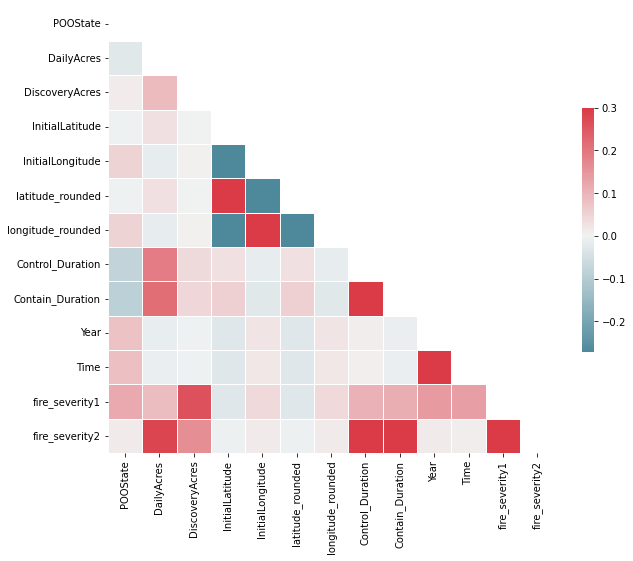

In [22]:
# correlation of the numerical features
corr = fires[['ControlDateTime', 'ContainmentDateTime', 'FireDiscoveryDateTime',
       'POOState', 'PredominantFuelModel', 'FireCauseGeneral', 'DailyAcres',
       'DiscoveryAcres', 'InitialLatitude', 'InitialLongitude',
       'latitude_rounded', 'longitude_rounded', 'CorrectControlDateTime',
       'CorrectContainmentDateTime', 'Control_Duration', 'Contain_Duration',
       'Year', 'Date', 'Time', 'fire_severity1', 'fire_severity2']].corr()

# generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(10,9))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={'shrink': .5})
#print(corr)

<AxesSubplot:>

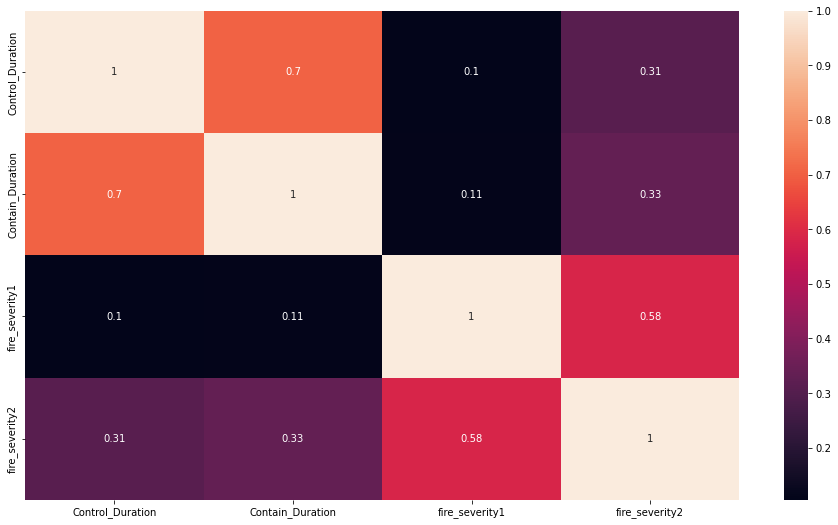

In [23]:
fires2=fires.loc[:,['Control_Duration', 'Contain_Duration', 'fire_severity1', 'fire_severity2']]

# transform the categorical features from fires2 dataframe through one hot encoding.
fires2=pd.get_dummies(fires2,columns=[])

# the correlation heatmap between each features so that it is easier to choose the best features
plt.figure(figsize=(16,9)),
sns.heatmap(fires2.corr(),annot=True)

In [24]:
#from sklearn.preprocessing import OneHotEncoder

#ohe = OneHotEncoder()
#ohe_features = ohe.fit_transform(fires[['Date', 'PredominantFuelModel', 'Control_Duration', 'Contain_Duration', 'fire_severity1', 'fire_severity2']])

In [25]:
fuelmodel_list = fires['PredominantFuelModel'].to_list()
fireseverity1_list = fires['fire_severity1'].to_list()
fireseverity2_list = fires['fire_severity2'].to_list()

#np.savez('one_hot.npz',fuelmodel_list = fuelmodel_list, fireseverity1_list = fireseverity1_list, fireseverity2_list = fireseverity2_list)

In [26]:
# Import LabelEncoder to convert Fuel Model and General Cause to Numeric Values
from sklearn.preprocessing import LabelEncoder

# Converting Fuel Model to Numeric and using Label encoders for this 
label_encoder = LabelEncoder()
fires["fueltype_num"] = label_encoder.fit_transform(fires["PredominantFuelModel"])
#fires["Control_Duration"] = label_encoder.fit_transform(fires["Control_Duration"])

In [27]:
fires_binary_encoded = pd.get_dummies(fires, columns=["PredominantFuelModel", "FireCauseGeneral"])
fires_binary_encoded = fires_binary_encoded.drop(['fueltype_num','CorrectControlDateTime','CorrectContainmentDateTime','ControlDateTime','ContainmentDateTime', 'Year', 'Date', 'Time','FireDiscoveryDateTime','DailyAcres','DiscoveryAcres','latitude_rounded','longitude_rounded','InitialLatitude','InitialLongitude','POOState'], axis=1)
fires_binary_encoded.head()

,Control_Duration,Contain_Duration,fire_severity1,fire_severity2,PredominantFuelModel_GR1,PredominantFuelModel_GR2,PredominantFuelModel_GR3,PredominantFuelModel_GR4,PredominantFuelModel_GR5,PredominantFuelModel_GR6,PredominantFuelModel_GR7,PredominantFuelModel_GR8,PredominantFuelModel_GR9,PredominantFuelModel_GS1,PredominantFuelModel_GS2,PredominantFuelModel_GS3,PredominantFuelModel_GS4,PredominantFuelModel_NB1,PredominantFuelModel_SB1,PredominantFuelModel_SB2,PredominantFuelModel_SB3,PredominantFuelModel_SB4,PredominantFuelModel_SH1,PredominantFuelModel_SH2,PredominantFuelModel_SH3,PredominantFuelModel_SH4,PredominantFuelModel_SH5,PredominantFuelModel_SH6,PredominantFuelModel_SH7,PredominantFuelModel_SH8,PredominantFuelModel_SH9,PredominantFuelModel_TL1,PredominantFuelModel_TL2,PredominantFuelModel_TL3,PredominantFuelModel_TL4,PredominantFuelModel_TL5,PredominantFuelModel_TL6,PredominantFuelModel_TL7,PredominantFuelModel_TL8,PredominantFuelModel_TL9,PredominantFuelModel_TU1,PredominantFuelModel_TU2,PredominantFuelModel_TU3,PredominantFuelModel_TU4,PredominantFuelModel_TU5,FireCauseGeneral_1,FireCauseGeneral_2,FireCauseGeneral_3
13551,15.000000,15.000000,2.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
154607,1.330556,1.330556,2.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
94872,1.479444,1.474167,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31810,1.857778,0.688889,2.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
77088,0.829167,0.825556,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Evaluate Regressors (Control Duration)

In [28]:
# The 20% test data will kept aside, they won't be seen by the models until final test/comparison.

model_train, model_test = train_test_split(fires_binary_encoded, test_size=0.20, random_state = 3)

control_model_train_x = model_train.drop(['Control_Duration'], axis = 1)
control_model_test_x = model_test.drop(['Control_Duration'], axis = 1)

control_model_train_y = model_train['Control_Duration']
control_model_test_y = model_test['Control_Duration']

### Linear Model & Linear Regression

0.018288850784301758  hour 


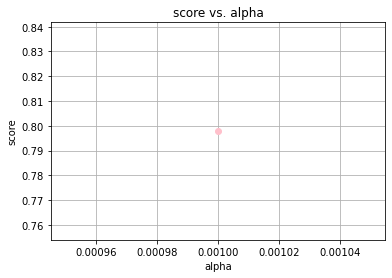

The optimaized alpha and score of Lasso linear is:  0.001 0.7978701062880339
1.9701640605926514  hour 


In [29]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge, ARDRegression
from sklearn.metrics import mean_squared_error, r2_score
import timeit,time

A = time.time()

control_lr_train, control_lr_validate = train_test_split(model_train, test_size=0.20, random_state = 0)

control_lr_train_x = control_lr_train.drop(['Control_Duration'], axis = 1)
control_lr_validate_x = control_lr_validate.drop(['Control_Duration'], axis = 1)
control_lr_train_y = control_lr_train['Control_Duration']
control_lr_validate_y = control_lr_validate['Control_Duration']

B = time.time()
print(B - A,' hour ')

del control_lr_train
del control_lr_validate

alphas = np.logspace(-3, 0, num=1)   # plot one point to see the score since computation takes too much time 
# alphas= [0.000000001]

scores = np.empty_like(alphas)
opt_a = float('-inf')            #  The optimaized alpha
max_score = float('-inf')        #  score of Lasso linear

for i, a in enumerate(alphas):
    lasso = skl.linear_model.Lasso(alpha = a,tol=0.01,normalize=False,max_iter=1000,selection='random')  # imported sklearn as sl
    lasso.fit(control_lr_train_x, control_lr_train_y)
    scores[i] = lasso.score(control_lr_validate_x, control_lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        lasso_save = lasso
plt.plot(alphas, scores, color='pink', linestyle='dashed', marker='o',markerfacecolor='pink', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print('The optimaized alpha and score of Lasso linear is: ', opt_a, max_score)

C = time.time()
print(C - B,' hour ')

In [30]:
lasso.score(control_model_test_x,control_model_test_y)

0.737272857664076

In [31]:
A = time.time()

Linear = LinearRegression(fit_intercept=True, normalize=False, n_jobs=-1)
Linear.fit(control_model_train_x.to_numpy(),control_model_train_y.to_numpy())

C = time.time()
print(C - A,' hour ')

Linear.score(control_model_train_x,control_model_train_y)

0.08729171752929688  hour 


0.47484816225102955

In [32]:
A = time.time()

Ridge = skl.linear_model.Ridge(alpha = a, normalize=False)
Ridge.fit(control_model_train_x.to_numpy(),control_model_train_y.to_numpy())
C = time.time()
print(C - A,' hour ')

Ridge.score(control_model_train_x,control_model_train_y)

0.021863222122192383  hour 


0.47484816225088233

In [33]:
A = time.time()

Bayesian = skl.linear_model.BayesianRidge()
Bayesian.fit(control_model_train_x.to_numpy(),control_model_train_y.to_numpy())
C = time.time()
print(C - A,' hour ')

Bayesian.score(control_model_train_x,control_model_train_y)

0.1342029571533203  hour 


0.47466292957179146

In [34]:
A = time.time()

ard = ARDRegression()
ard.fit(control_model_train_x.to_numpy(),control_model_train_y.to_numpy())
C = time.time()
print(C - A,' hour ')

ard.score(control_model_train_x,control_model_train_y)

1.353637933731079  hour 


0.4747124382273461

### Decision Tree Regressor

In [35]:
from sklearn.tree import DecisionTreeRegressor

control_dt_train, control_dt_validate = train_test_split(model_train, test_size=0.20, random_state = 0)

control_dt_train_x = control_dt_train.drop(['Control_Duration'], axis = 1)
control_dt_validate_x = control_dt_validate.drop(['Control_Duration'], axis = 1)
control_dt_train_y = control_dt_train['Control_Duration']
control_dt_validate_y = control_dt_validate['Control_Duration']

Tree = DecisionTreeRegressor(
    criterion='squared_error',
    splitter='best',
    max_depth=None,
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features=None, 
    random_state=None, 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    ccp_alpha=0.0)

Tree.fit(control_dt_train_x, control_dt_train_y)

C = time.time()
print(C - A,' hour ')

1.6873910427093506  hour 


In [36]:
A = time.time()
print(Tree.score(control_dt_validate_x, control_dt_validate_y))
C = time.time()
print(C - A,' hour ')

0.5382807593449351
0.006741046905517578  hour 


### Random Forest Regressor

In [37]:
from sklearn.ensemble import RandomForestRegressor

A = time.time()

control_rf_train, control_rf_validate = train_test_split(model_train, test_size=0.20, random_state = 0)

control_rf_train_x = control_rf_train.drop(['Control_Duration'], axis = 1)
control_rf_validate_x = control_rf_validate.drop(['Control_Duration'], axis = 1)
control_rf_train_y = control_rf_train['Control_Duration']
control_rf_validate_y = control_rf_validate['Control_Duration']

Forest = RandomForestRegressor(
    n_estimators=10,
    criterion='squared_error', 
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features='auto', 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    bootstrap=True, 
    oob_score=False, 
    n_jobs=-1, 
    random_state=None, 
    verbose=0, 
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None)

Forest.fit(control_rf_train_x, control_rf_train_y)

C = time.time()
print(C - A,' hour ')

0.2942991256713867  hour 


In [38]:
A = time.time()
print(Forest.score(control_rf_validate_x, control_rf_validate_y))
C = time.time()
print(C - A,' hour ')

0.7323912913310511
0.016882896423339844  hour 


### k-Nearest Neighbor Regressor

In [39]:
from sklearn.neighbors import KNeighborsRegressor

control_kn_train, control_kn_validate = train_test_split(model_train, test_size=0.20, random_state = 0)

control_kn_train_x = control_kn_train.drop(['Control_Duration'], axis = 1)
control_kn_validate_x = control_kn_validate.drop(['Control_Duration'], axis = 1)
control_kn_train_y = control_kn_train['Control_Duration']
control_kn_validate_y = control_kn_validate['Control_Duration']

KNN = KNeighborsRegressor(
    n_neighbors=10,
    weights='uniform',
    algorithm='auto',
    leaf_size=30, 
    p=2,  
    metric='minkowski',  
    metric_params=None, 
    n_jobs=None)

KNN.fit(control_kn_train_x, control_kn_train_y)

C = time.time()
print(C - A,' hour ')

0.05527186393737793  hour 


In [40]:
A = time.time()
print(KNN.score(control_kn_validate_x, control_kn_validate_y))
C = time.time()
print(C - A,' hour ')

0.7434927676019005
16.210670948028564  hour 


### MLP Regressor 

In [41]:
from sklearn.neural_network import MLPRegressor

A = time.time()

control_mlp_train, control_mlp_validate = train_test_split(model_train, test_size=0.20, random_state = 0)

control_mlp_train_x = control_mlp_train.drop(['Control_Duration'], axis = 1)
control_mlp_validate_x = control_mlp_validate.drop(['Control_Duration'], axis = 1)
control_mlp_train_y = control_mlp_train['Control_Duration']
control_mlp_validate_y = control_mlp_validate['Control_Duration']

MLP = MLPRegressor(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam', 
    alpha=0.0001,
    batch_size='auto', 
    learning_rate='constant', 
    learning_rate_init=0.001, 
    power_t=0.5, 
    max_iter=200, 
    shuffle=True, 
    random_state=None, 
    tol=0.0001, 
    verbose=False, 
    warm_start=False, 
    momentum=0.9, 
    nesterovs_momentum=True, 
    early_stopping=False, 
    validation_fraction=0.1, 
    beta_1=0.9, 
    beta_2=0.999, 
    epsilon=1e-08, 
    n_iter_no_change=10, 
    max_fun=15000)

MLP.fit(control_mlp_train_x, control_mlp_train_y)

C = time.time()
print(C - A,' hour ')

16.601750135421753  hour 


In [42]:
A = time.time()
print(MLP.score(control_mlp_validate_x, control_mlp_validate_y))
C = time.time()
print(C - A,' hour ')

0.7998380785134502
0.01941990852355957  hour 


### SVR

In [43]:
from sklearn.svm import SVR

A = time.time()

control_svr_train, control_svr_validate = train_test_split(model_train, test_size=0.20, random_state = 0)

control_svr_train_x = control_svr_train.drop(['Control_Duration'], axis = 1)
control_svr_validate_x = control_svr_validate.drop(['Control_Duration'], axis = 1)
control_svr_train_y = control_svr_train['Control_Duration']
control_svr_validate_y = control_svr_validate['Control_Duration']

SVR = SVR(
    kernel='rbf', 
    degree=3, 
    gamma='scale', 
    coef0=0.0, 
    tol=0.001, 
    C=1.0, 
    epsilon=0.1, 
    shrinking=True, 
    cache_size=200, 
    verbose=False, 
    max_iter=- 1)

SVR.fit(control_svr_train_x, control_svr_train_y)

C = time.time()
print(C - A,' hour ')

1028.151057958603  hour 


In [44]:
A = time.time()
print(SVR.score(control_svr_validate_x, control_svr_validate_y))
C = time.time()
print(C - A,' hour ')

0.4476791103825444
147.0304718017578  hour 


# Model Evaluation (Control Duration)

Test data is the reserved 20% of the whole dataset, and has never been seen by the above models.


### Linear Score (L)

In [45]:
control_L_score = Linear.score(control_model_test_x, control_model_test_y)

control_pred_y = Linear.predict(control_model_test_x)
control_MSE_L = mean_squared_error(control_model_test_y, control_pred_y)
control_RMSE_L = sqrt(mean_squared_error(control_model_test_y, control_pred_y))

# The mean squared error and root mean square error
print('L score: ', control_L_score)
print('Mean square error of L: ', control_MSE_L)
print('Root mean squared error of L:', control_RMSE_L)

L score:  0.7372205075550067
Mean square error of L:  37522.60021695796
Root mean squared error of L: 193.70751203027197


### Decision Tree Score (dt)

In [46]:
control_dt_score = Tree.score(control_model_test_x, control_model_test_y)

control_pred_y = Tree.predict(control_model_test_x)
control_MSE_dt = mean_squared_error(control_model_test_y, control_pred_y)
control_RMSE_dt = sqrt(mean_squared_error(control_model_test_y, control_pred_y))

# The mean squared error and root mean square error
print('dt score: ', control_dt_score)
print('Mean square error of dt: ', control_MSE_dt)
print('Root mean squared error of dt:', control_RMSE_dt)

dt score:  0.6116181575820373
Mean square error of dt:  55457.51104464633
Root mean squared error of dt: 235.49418473636737


### k-Nearest Neighbor Score (kn)

In [47]:
control_kn_score = KNN.score(control_model_test_x, control_model_test_y)

control_pred_y = KNN.predict(control_model_test_x)
control_MSE_kn = mean_squared_error(control_model_test_y, control_pred_y)
control_RMSE_kn = sqrt(mean_squared_error(control_model_test_y, control_pred_y))

# The mean squared error and root mean square error
print('kn score: ', control_kn_score)
print('Mean square error of kn: ', control_MSE_kn)
print('Root mean squared error of kn:', control_RMSE_kn)

kn score:  0.7310790692868783
Mean square error of kn:  38399.54358399161
Root mean squared error of kn: 195.95801485009898


### Random Forest Score (rf)

In [48]:
control_rf_score = Forest.score(control_model_test_x, control_model_test_y)

control_pred_y = Forest.predict(control_model_test_x)
control_MSE_rf = mean_squared_error(control_model_test_y, control_pred_y)
control_RMSE_rf = sqrt(mean_squared_error(control_model_test_y, control_pred_y))

# The mean squared error and root mean square error
print('rf score: ', control_rf_score)
print('Mean square error of rf: ', control_MSE_rf)
print('Root mean squared error of rf:', control_RMSE_rf)
# print('Coefficients: \n', ridge_fp.coef_)

rf score:  0.6401590934298754
Mean square error of rf:  51382.116440326325
Root mean squared error of rf: 226.67623704377644


### MLP Score (mlp) 

In [49]:
control_mlp_score = MLP.score(control_model_test_x, control_model_test_y)

control_pred_y = MLP.predict(control_model_test_x)
control_MSE_mlp = mean_squared_error(control_model_test_y, control_pred_y)
control_RMSE_mlp = sqrt(mean_squared_error(control_model_test_y, control_pred_y))

# The mean squared error and root mean square error
print('mlp score: ', control_mlp_score)
print('Mean square error of mlp: ', control_MSE_mlp)
print('Root mean squared error of mlp:', control_RMSE_mlp)
# print('Coefficients: \n', ridge_fp.coef_)

mlp score:  0.7574099548418158
Mean square error of mlp:  34639.72472277202
Root mean squared error of mlp: 186.11750246221342


### SVR Score (svr) 

In [50]:
control_svr_score = SVR.score(control_model_test_x, control_model_test_y)

control_pred_y = SVR.predict(control_model_test_x)
control_MSE_svr = mean_squared_error(control_model_test_y, control_pred_y)
control_RMSE_svr = sqrt(mean_squared_error(control_model_test_y, control_pred_y))

# The mean squared error and root mean square error
print('svr score: ', control_svr_score)
print('Mean square error of svr: ', control_MSE_svr)
print('Root mean squared error of svr:', control_RMSE_svr)
# print('Coefficients: \n', ridge_fp.coef_)

svr score:  0.4536089243533149
Mean square error of svr:  78019.83976316494
Root mean squared error of svr: 279.3203174908065


# Comparison of the models (Control Duration)

Compared the max_score, mean squared error (MSE), and root mean squared error (RMSE) of the models.

Random forest model rf returns the beset prediction accuracy.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


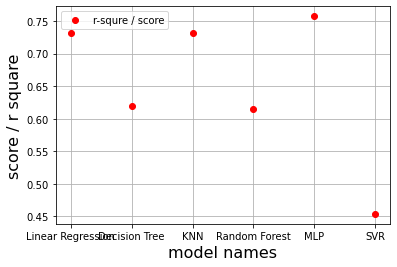

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


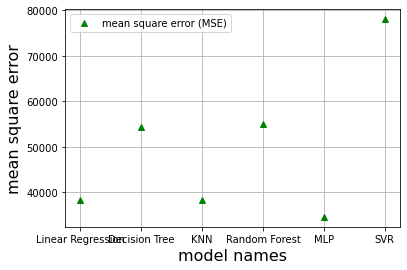

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


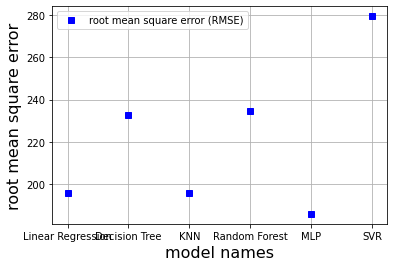

In [54]:
control_lst_score = [0.7309242395008656, 0.6199126543612643, 0.7310790692868783, 0.6147714918055145, 0.7574099548418158, 0.4536089243533149]
control_MSE_lst =  [38421.65191561283, 54273.12985967646, 38399.54358399161, 55007.242653010864, 34639.72472277202, 78019.83976316494]
control_RMSE_lst =  [196.0144176217985, 232.96594141564225, 195.95801485009898, 234.536228870959, 186.11750246221342, 279.3203174908065]
control_model_lst = ['Linear Regression', 'Decision Tree', 'KNN', 'Random Forest', 'MLP', 'SVR']

plt.figure(1)
plt.plot(control_model_lst, control_lst_score, 'ro')
plt.legend(loc = 9)
plt.legend(['r-squre / score'])
plt.xlabel('model names',fontsize =16)
plt.ylabel('score / r square', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(2)
plt.plot(control_model_lst, control_MSE_lst, 'g^')
plt.legend(loc = 9)
plt.legend(['mean square error (MSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('mean square error', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(3)
plt.plot(control_model_lst, control_RMSE_lst, 'bs')
plt.legend(loc = 9)
plt.legend(['root mean square error (RMSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('root mean square error', fontsize =16)
plt.grid(True)
plt.show()

# Evaluate Regressors (Contain Duration)

In [57]:
# The 20% test data will kept aside, they won't be seen by the models until final test/comparison.

model_train, model_test = train_test_split(fires_binary_encoded, test_size=0.20, random_state = 3)

contain_model_train_x = model_train.drop(['Contain_Duration'], axis = 1)
contain_model_test_x = model_test.drop(['Contain_Duration'], axis = 1)

contain_model_train_y = model_train['Contain_Duration']
contain_model_test_y = model_test['Contain_Duration']

### Linear Model & Linear Regression

0.02284407615661621  hour 


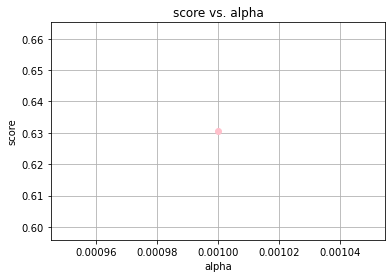

The optimaized alpha and score of Lasso linear is:  0.001 0.630562240753105
0.882843017578125  hour 


In [58]:
import timeit,time

A = time.time()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing

contain_lr_train, contain_lr_validate = train_test_split(model_train, test_size=0.20, random_state = 0)

contain_lr_train_x = contain_lr_train.drop(['Contain_Duration'], axis = 1)
contain_lr_validate_x = contain_lr_validate.drop(['Contain_Duration'], axis = 1)
contain_lr_train_y = contain_lr_train['Contain_Duration']
contain_lr_validate_y = contain_lr_validate['Contain_Duration']

B = time.time()
print(B - A,' hour ')

del contain_lr_train
del contain_lr_validate

alphas = np.logspace(-3, 0, num=1)   # plot one point to see the score since computation takes too much time 
# alphas= [0.000000001]

scores = np.empty_like(alphas)
opt_a = float('-inf')            #  The optimaized alpha
max_score = float('-inf')        #  score of Lasso linear

for i, a in enumerate(alphas):
    lasso = skl.linear_model.Lasso(alpha = a,tol=0.01,normalize=False,max_iter=1000,selection='random')  # imported sklearn as sl
    lasso.fit(contain_lr_train_x, contain_lr_train_y)
    scores[i] = lasso.score(contain_lr_validate_x, contain_lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        lasso_save = lasso
plt.plot(alphas, scores, color='pink', linestyle='dashed', marker='o',markerfacecolor='pink', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print('The optimaized alpha and score of Lasso linear is: ', opt_a, max_score)

C = time.time()
print(C - B,' hour ')

In [59]:
lasso.score(contain_model_test_x,contain_model_test_y)

0.5832742572104803

In [60]:
A = time.time()

Linear = LinearRegression(fit_intercept=True, normalize=False, n_jobs=-1)
Linear.fit(contain_model_train_x.to_numpy(),contain_model_train_y.to_numpy())

C = time.time()
print(C - A,' hour ')

0.08536601066589355  hour 


In [61]:
Linear.score(contain_model_train_x,contain_model_train_y)

0.49370062198737263

In [62]:
A = time.time()

Ridge = skl.linear_model.Ridge(alpha = a, normalize=False)
Ridge.fit(contain_model_train_x.to_numpy(),contain_model_train_y.to_numpy())
C = time.time()
print(C - A,' hour ')

Ridge.score(contain_model_train_x,contain_model_train_y)

0.046227216720581055  hour 


0.4937006219870942

In [63]:
A = time.time()

Bayesian = skl.linear_model.BayesianRidge()
Bayesian.fit(contain_model_train_x.to_numpy(),contain_model_train_y.to_numpy())
C = time.time()
print(C - A,' hour ')

Bayesian.score(contain_model_train_x,contain_model_train_y)

0.16036081314086914  hour 


0.4936172446913887

In [64]:
A = time.time()

ard = ARDRegression()
ard.fit(contain_model_train_x.to_numpy(),contain_model_train_y.to_numpy())
C = time.time()
print(C - A,' hour ')

ard.score(contain_model_train_x,contain_model_train_y)

2.086146116256714  hour 


0.49360988627793667

### Decision Tree Regressor 

In [65]:
from sklearn.tree import DecisionTreeRegressor

contain_dt_train, contain_dt_validate = train_test_split(model_train, test_size=0.20, random_state = 0)

contain_dt_train_x = contain_dt_train.drop(['Contain_Duration'], axis = 1)
contain_dt_validate_x = contain_dt_validate.drop(['Contain_Duration'], axis = 1)
contain_dt_train_y = contain_dt_train['Contain_Duration']
contain_dt_validate_y = contain_dt_validate['Contain_Duration']

Tree = DecisionTreeRegressor(
    criterion='squared_error',
    splitter='best',
    max_depth=None,
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features=None, 
    random_state=None, 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    ccp_alpha=0.0)

Tree.fit(contain_dt_train_x, contain_dt_train_y)

C = time.time()
print(C - A,' hour ')

5.875259876251221  hour 


In [66]:
A = time.time()
print(Tree.score(contain_dt_validate_x, contain_dt_validate_y))
C = time.time()
print(C - A,' hour ')

0.6691187665924234
0.02341008186340332  hour 


### Random Forest Regressor

In [67]:
from sklearn.ensemble import RandomForestRegressor

A = time.time()

contain_rf_train, contain_rf_validate = train_test_split(model_train, test_size=0.20, random_state = 0)

contain_rf_train_x = contain_rf_train.drop(['Contain_Duration'], axis = 1)
contain_rf_validate_x = contain_rf_validate.drop(['Contain_Duration'], axis = 1)
contain_rf_train_y = contain_rf_train['Contain_Duration']
contain_rf_validate_y = contain_rf_validate['Contain_Duration']

Forest = RandomForestRegressor(
    n_estimators=10,
    criterion='squared_error', 
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features='auto', 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    bootstrap=True, 
    oob_score=False, 
    n_jobs=-1, 
    random_state=None, 
    verbose=0, 
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None)

Forest.fit(contain_rf_train_x, contain_rf_train_y)

C = time.time()
print(C - A,' hour ')

0.287945032119751  hour 


In [68]:
A = time.time()
print(Forest.score(contain_rf_validate_x, contain_rf_validate_y))
C = time.time()
print(C - A,' hour ')

0.8061628029009664
0.030384063720703125  hour 


### KNN Regressor

In [69]:
from sklearn.neighbors import KNeighborsRegressor

contain_kn_train, contain_kn_validate = train_test_split(model_train, test_size=0.20, random_state = 0)

contain_kn_train_x = contain_kn_train.drop(['Contain_Duration'], axis = 1)
contain_kn_validate_x = contain_kn_validate.drop(['Contain_Duration'], axis = 1)
contain_kn_train_y = contain_kn_train['Contain_Duration']
contain_kn_validate_y = contain_kn_validate['Contain_Duration']


KNN = KNeighborsRegressor(
    n_neighbors=10,
    weights='uniform',
    algorithm='auto',
    leaf_size=30, 
    p=2,  
    metric='minkowski',  
    metric_params=None, 
    n_jobs=None)

KNN.fit(contain_kn_train_x, contain_kn_train_y)

C = time.time()
print(C - A,' hour ')

12.310903072357178  hour 


In [70]:
A = time.time()
print(KNN.score(contain_kn_validate_x, contain_kn_validate_y))
C = time.time()
print(C - A,' hour ')

0.8171392481157824
16.568870067596436  hour 


### MLP Regressor 

In [71]:
from sklearn.neural_network import MLPRegressor

A = time.time()

contain_mlp_train, contain_mlp_validate = train_test_split(model_train, test_size=0.20, random_state = 0)

contain_mlp_train_x = contain_mlp_train.drop(['Contain_Duration'], axis = 1)
contain_mlp_validate_x = contain_mlp_validate.drop(['Contain_Duration'], axis = 1)
contain_mlp_train_y = contain_mlp_train['Contain_Duration']
contain_mlp_validate_y = contain_mlp_validate['Contain_Duration']

MLP = MLPRegressor(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam', 
    alpha=0.0001,
    batch_size='auto', 
    learning_rate='constant', 
    learning_rate_init=0.001, 
    power_t=0.5, 
    max_iter=200, 
    shuffle=True, 
    random_state=None, 
    tol=0.0001, 
    verbose=False, 
    warm_start=False, 
    momentum=0.9, 
    nesterovs_momentum=True, 
    early_stopping=False, 
    validation_fraction=0.1, 
    beta_1=0.9, 
    beta_2=0.999, 
    epsilon=1e-08, 
    n_iter_no_change=10, 
    max_fun=15000)

MLP.fit(contain_mlp_train_x, contain_mlp_train_y)

C = time.time()
print(C - A,' hour ')

24.763266801834106  hour 


In [72]:
A = time.time()
print(MLP.score(contain_mlp_validate_x, contain_mlp_validate_y))
C = time.time()
print(C - A,' hour ')

0.8046048281744076
0.008000850677490234  hour 


### SVR 

In [73]:
from sklearn.svm import SVR

A = time.time()

contain_svr_train, contain_svr_validate = train_test_split(model_train, test_size=0.20, random_state = 0)

contain_svr_train_x = contain_svr_train.drop(['Contain_Duration'], axis = 1)
contain_svr_validate_x = contain_svr_validate.drop(['Contain_Duration'], axis = 1)
contain_svr_train_y = contain_svr_train['Contain_Duration']
contain_svr_validate_y = contain_svr_validate['Contain_Duration']

SVR = SVR(
    kernel='rbf', 
    degree=3, 
    gamma='scale', 
    coef0=0.0, 
    tol=0.001, 
    C=1.0, 
    epsilon=0.1, 
    shrinking=True, 
    cache_size=200, 
    verbose=False, 
    max_iter=- 1)

SVR.fit(contain_svr_train_x, contain_svr_train_y)

C = time.time()
print(C - A,' hour ')

566.4334042072296  hour 


In [74]:
A = time.time()
print(SVR.score(contain_svr_validate_x, contain_svr_validate_y))
C = time.time()
print(C - A,' hour ')

0.4199040118331471
144.46393084526062  hour 


# Model Evaluation (Contain Duration)

Test data is the reserved 20% of the whole dataset, and has never been seen by the above models.


### Linear Regression (L)

In [75]:
contain_L_score = Linear.score(contain_model_test_x, contain_model_test_y)

contain_pred_y = Linear.predict(contain_model_test_x)
contain_MSE_L = mean_squared_error(contain_model_test_y, contain_pred_y)
contain_RMSE_L = sqrt(mean_squared_error(contain_model_test_y, contain_pred_y))

# The mean squared error and root mean square error
print('L score: ', contain_L_score)
print('Mean square error of L: ', contain_MSE_L)
print('Root mean squared error of L:', contain_RMSE_L)

L score:  0.6087429019487529
Mean square error of L:  43160.79265286026
Root mean squared error of L: 207.75175727983688


### Decision Tree (dt)

In [76]:
contain_dt_score = Tree.score(contain_model_test_x, contain_model_test_y)

contain_pred_y = Tree.predict(contain_model_test_x)
contain_MSE_dt = mean_squared_error(contain_model_test_y, contain_pred_y)
contain_RMSE_dt = sqrt(mean_squared_error(contain_model_test_y, contain_pred_y))

# The mean squared error and root mean square error
print('dt score: ', contain_dt_score)
print('Mean square error of dt: ', contain_MSE_dt)
print('Root mean squared error of dt:', contain_RMSE_dt)

dt score:  0.6098492246688078
Mean square error of dt:  43038.75073779913
Root mean squared error of dt: 207.4578288178085


### k-Nearest Neighbor Score (kn)

In [77]:
contain_kn_score = KNN.score(contain_model_test_x, contain_model_test_y)

contain_pred_y = KNN.predict(contain_model_test_x)
contain_MSE_kn = mean_squared_error(contain_model_test_y, contain_pred_y)
contain_RMSE_kn = sqrt(mean_squared_error(contain_model_test_y, contain_pred_y))

# The mean squared error and root mean square error
print('kn score: ', contain_kn_score)
print('Mean square error of kn: ', contain_MSE_kn)
print('Root mean squared error of kn:', contain_RMSE_kn)

kn score:  0.7189059343811524
Mean square error of kn:  31008.364429814104
Root mean squared error of kn: 176.09192039901802


### Random Forest (rf)

In [78]:
contain_rf_score = Forest.score(contain_model_test_x, contain_model_test_y)

contain_pred_y = Forest.predict(contain_model_test_x)
contain_MSE_rf = mean_squared_error(contain_model_test_y, contain_pred_y)
contain_RMSE_rf = sqrt(mean_squared_error(contain_model_test_y, contain_pred_y))

# The mean squared error and root mean square error
print('rf score: ', contain_rf_score)
print('Mean square error of rf: ', contain_MSE_rf)
print('Root mean squared error of rf:', contain_RMSE_rf)
# print('Coefficients: \n', ridge_fp.coef_)

rf score:  0.6995149070720891
Mean square error of rf:  33147.44922388168
Root mean squared error of rf: 182.06440954750514


### MLP Score (mlp) 

In [79]:
contain_mlp_score = MLP.score(contain_model_test_x, contain_model_test_y)

contain_pred_y = MLP.predict(contain_model_test_x)
contain_MSE_mlp = mean_squared_error(contain_model_test_y, contain_pred_y)
contain_RMSE_mlp = sqrt(mean_squared_error(contain_model_test_y, contain_pred_y))

# The mean squared error and root mean square error
print('mlp score: ', contain_mlp_score)
print('Mean square error of mlp: ', contain_MSE_mlp)
print('Root mean squared error of mlp:', contain_RMSE_mlp)
# print('Coefficients: \n', ridge_fp.coef_)

mlp score:  0.7350448815893134
Mean square error of mlp:  29228.026750174984
Root mean squared error of mlp: 170.96206231259316


### SVR Score (svr) 

In [80]:
contain_svr_score = SVR.score(contain_model_test_x, contain_model_test_y)

contain_pred_y = SVR.predict(contain_model_test_x)
contain_MSE_svr = mean_squared_error(contain_model_test_y, contain_pred_y)
contain_RMSE_svr = sqrt(mean_squared_error(contain_model_test_y, contain_pred_y))

# The mean squared error and root mean square error
print('svr score: ', contain_svr_score)
print('Mean square error of svr: ', contain_MSE_svr)
print('Root mean squared error of svr:', contain_RMSE_svr)
# print('Coefficients: \n', ridge_fp.coef_)

svr score:  0.40273556924282927
Mean square error of svr:  65886.1050271921
Root mean squared error of svr: 256.68288806851166


# Comparison of the models (Contain Duration)

Compared the max_score, mean squared error (MSE), and root mean squared error (RMSE) of the models.

Random forest model rf returns the beset prediction accuracy.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


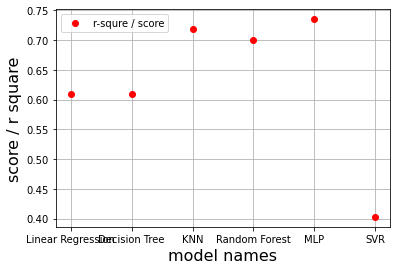

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


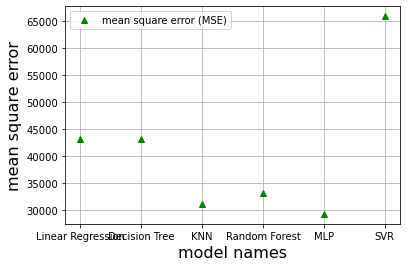

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


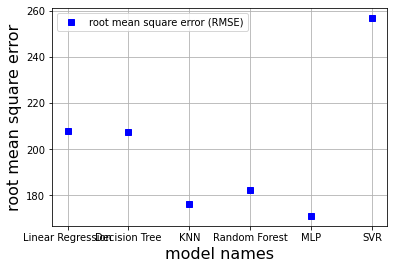

In [81]:
contain_lst_score = [0.6087429019487529,0.6098492246688078,0.7189059343811524,0.6995149070720891,0.7350448815893134,0.40273556924282927]
contain_MSE_lst =  [43160.79265286026,43038.75073779913,31008.364429814104,33147.44922388168,29228.026750174984,65886.1050271921]
contain_RMSE_lst =  [207.75175727983688,207.4578288178085,176.09192039901802,182.06440954750514,170.96206231259316,256.68288806851166]
contain_model_lst = ['Linear Regression', 'Decision Tree', 'KNN', 'Random Forest', 'MLP', 'SVR']

plt.figure(1)
plt.plot(contain_model_lst, contain_lst_score, 'ro')
plt.legend(loc = 9)
plt.legend(['r-squre / score'])
plt.xlabel('model names',fontsize =16)
plt.ylabel('score / r square', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(2)
plt.plot(contain_model_lst, contain_MSE_lst, 'g^')
plt.legend(loc = 9)
plt.legend(['mean square error (MSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('mean square error', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(3)
plt.plot(contain_model_lst, contain_RMSE_lst, 'bs')
plt.legend(loc = 9)
plt.legend(['root mean square error (RMSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('root mean square error', fontsize =16)
plt.grid(True)
plt.show()

The linear regression ranks the first place base on Control_Duration and random forest ranks the first place base on Contain_Duration, will use these two for the prediction